In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb

from model.vit_counter import LightningViTCounter

from glob import glob
import matplotlib.pyplot as plt

from torchvision import transforms
from PIL import Image
import random

### SAM Large

In [44]:
train_images_list = glob("../Datasets/DCC/trainval/images/*.png")
val_images_list = glob("../Datasets/DCC/test/images/*.png")
test_images_list = glob("../Datasets/DCC/test/images/*.png")

config_L = {
            'lr': 1e-4,
            'batch_size': 2,
            'conv_layers': 1,
            'drop_rate': 0,
            'vit_structure': 'SAM-L',
            'model_path': 'weights/sam_vit_l.pth',
            'freeze':True,
        }

mode_L = LightningViTCounter(
    train_images_list=train_images_list,
    val_images_list=val_images_list,
    test_images_list=test_images_list,
    config=config_L
)

mode_L.load_pretrained_encoder()

encoder_L = mode_L.encoder

print(f"Loaded the pretrained model")

Loading checkpoint: <All keys matched successfully>
Loaded the pretrained model


In [45]:
# random input tensor 
img = Image.open(random.choice(train_images_list))
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

rand_input = transform(img).unsqueeze(0)

# get the output of the encoder
mean_tensor, output, extracted_layers = encoder_L(rand_input)

# detach the tensor from the graph
mean_tensor = mean_tensor.detach()
output = output.detach()


print(f"Mean tensor shape: {mean_tensor.shape}")
print(f"Output tensor shape: {output.shape}")
print(f"Length of extracted layers: {len(extracted_layers)}")


Mean tensor shape: torch.Size([1, 256])
Output tensor shape: torch.Size([1, 256, 14, 14])
Length of extracted layers: 4


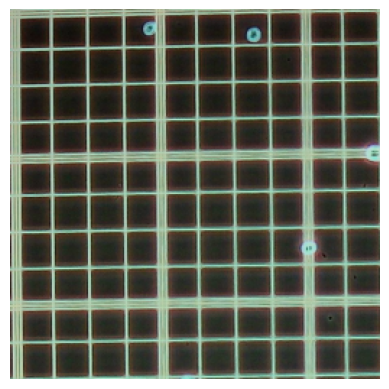

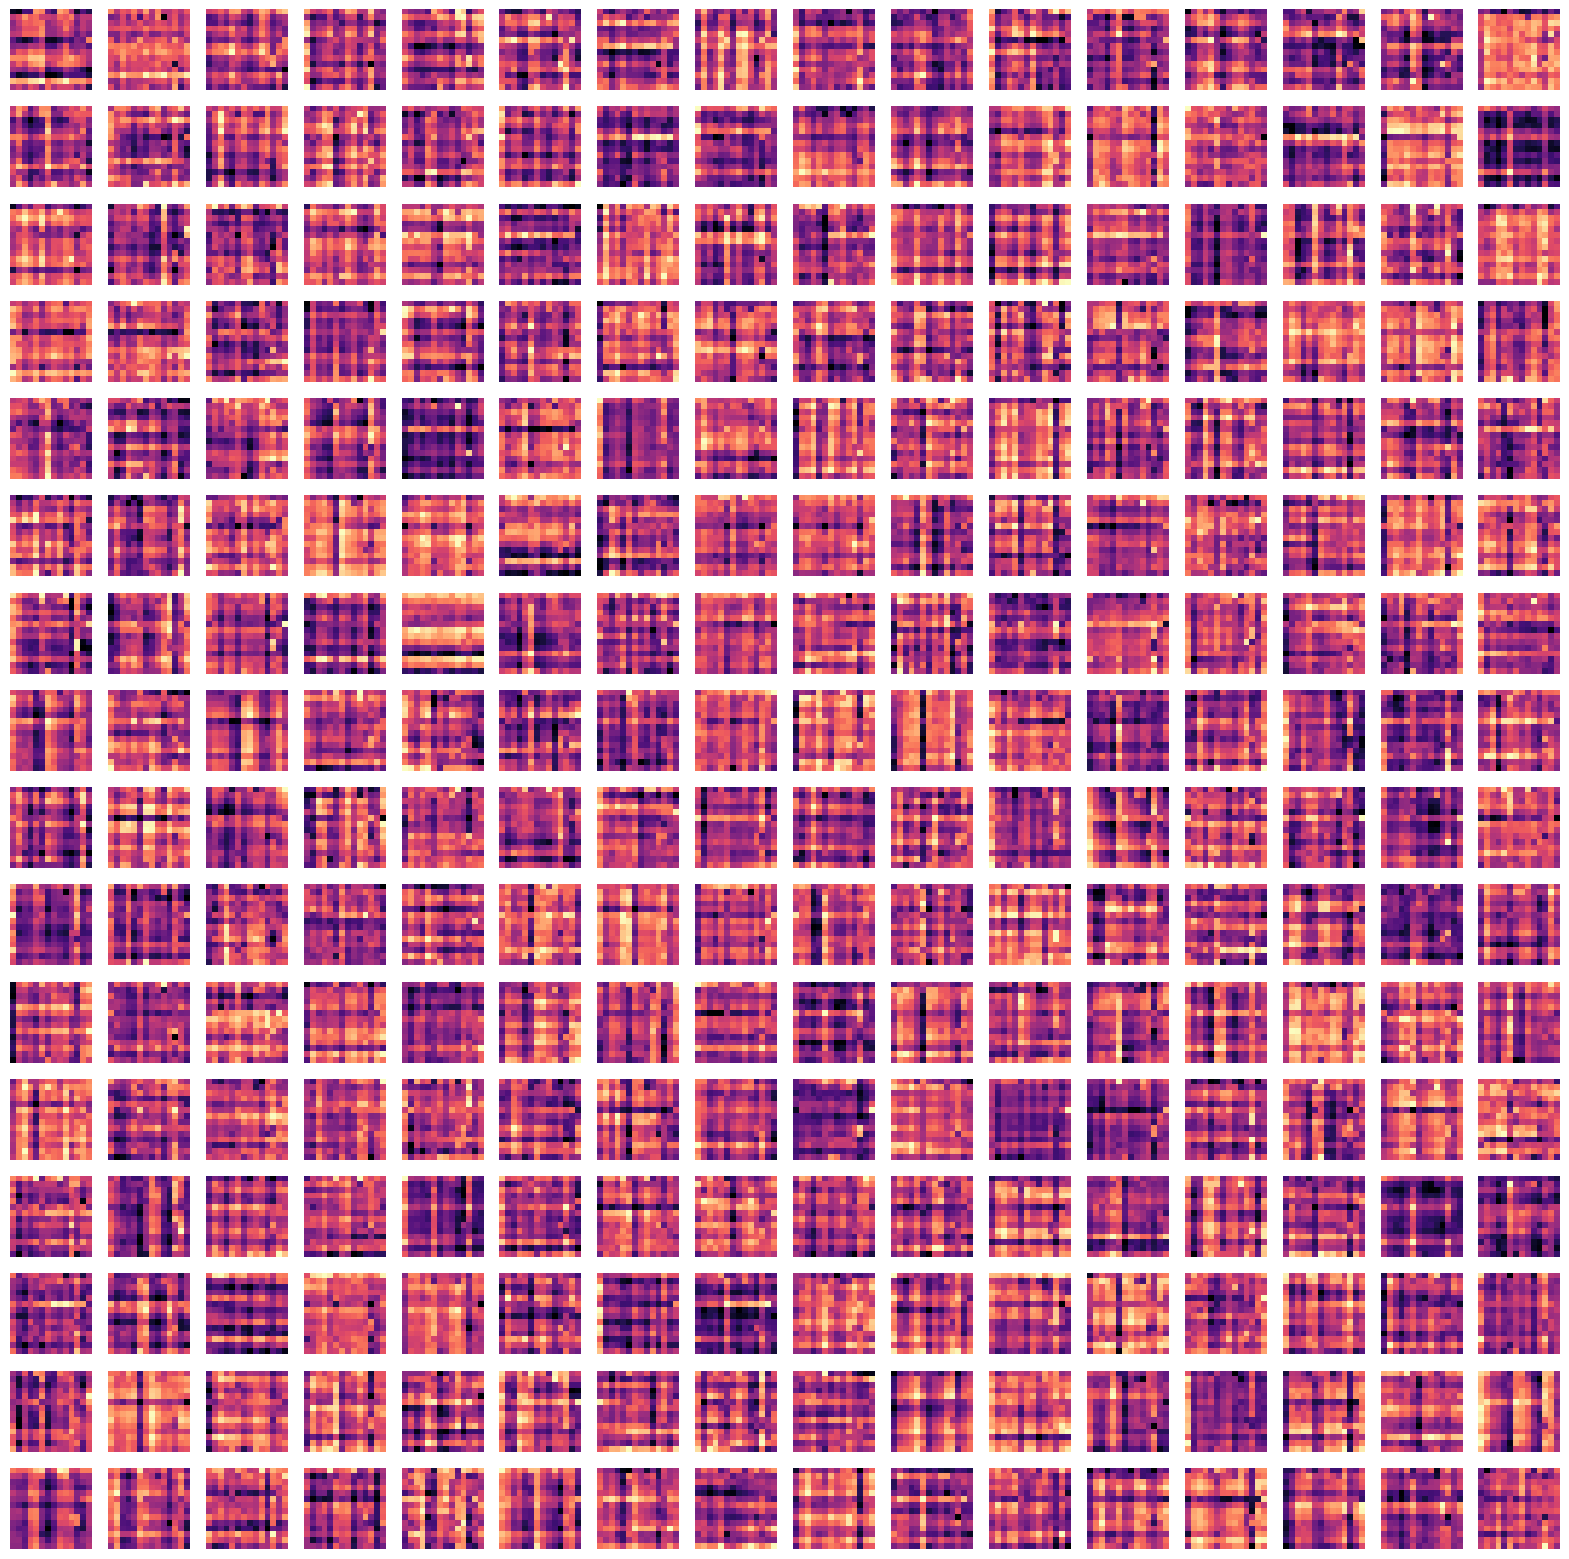

In [46]:
plt.imshow(img)
plt.axis('off')
plt.show()


# 16 x 16 subplots
fig, axs = plt.subplots(16, 16, figsize=(20,20))

# show all 256 feature maps in the output tensor
for i in range(16):
    for j in range(16):
        axs[i, j].imshow(output[0, i*16+j].cpu().numpy(), cmap = 'magma')
        axs[i, j].axis('off')

plt.show()





### SAM Huge

In [55]:
config_H = {
            'lr': 1e-4,
            'batch_size': 2,
            'conv_layers': 1,
            'drop_rate': 0,
            'vit_structure': 'SAM-H',
            'model_path': 'weights/sam_vit_h.pth',
            'freeze':True,
        }

model_H = LightningViTCounter(
    train_images_list=train_images_list,
    val_images_list=val_images_list,
    test_images_list=test_images_list,
    config=config_H
)

model_H.load_pretrained_encoder()

encoder_H = model_H.encoder

print(f"Loaded the pretrained model")

Loading checkpoint: <All keys matched successfully>
Loaded the pretrained model


In [60]:
# random input tensor
img = Image.open(random.choice(train_images_list))
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

rand_input = transform(img).unsqueeze(0)

# get the output of the encoder
mean_tensor, output, extracted_layers = encoder_H(rand_input)

# detach the tensor from the graph
mean_tensor = mean_tensor.detach()
output = output.detach()


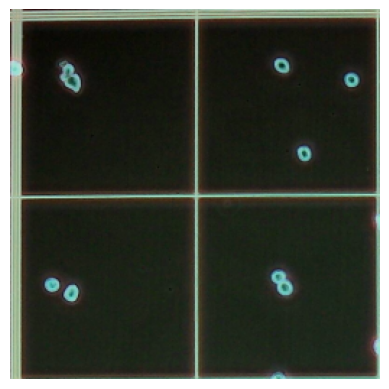

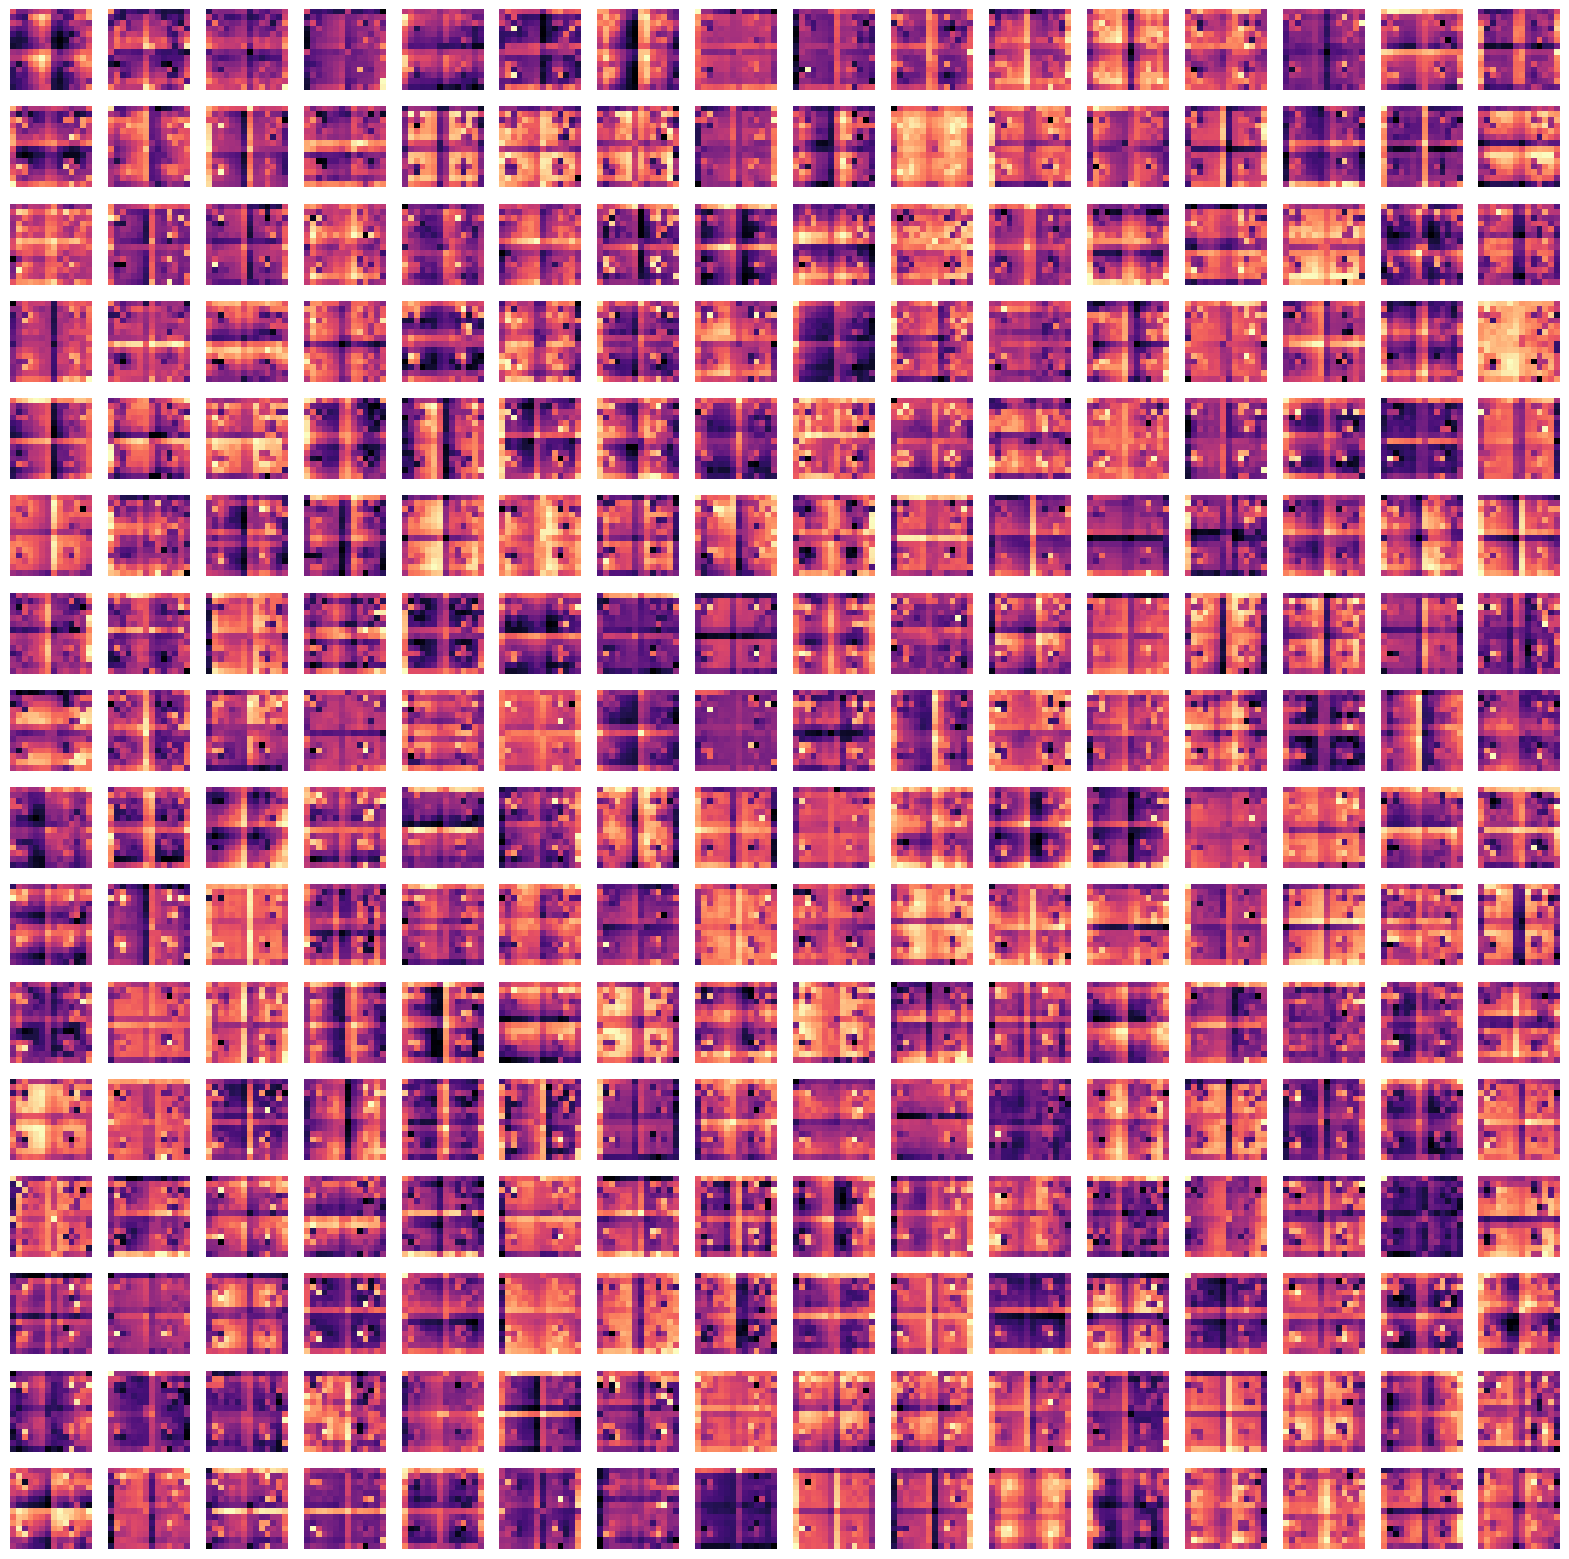

In [61]:
plt.imshow(img)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(16, 16, figsize=(20,20))

for i in range(16):
    for j in range(16):
        axs[i, j].imshow(output[0, i*16+j].cpu().numpy(), cmap = 'magma')
        axs[i, j].axis('off')

plt.show()

### Fine Tuned SAM

In [62]:
config_ft = {
            'lr': 1e-4,
            'batch_size': 2,
            'conv_layers': 1,
            'drop_rate': 0,
            'vit_structure': 'SAM-H',
            'model_path': 'weights/sam_vit_h.pth',
            'freeze':False,
        }

model_ft = LightningViTCounter.load_from_checkpoint('ckpts/iwvaj4ov/epoch=166-val_mae=3.48.ckpt', train_images_list=train_images_list, val_images_list=val_images_list, test_images_list=test_images_list, config=config_ft)

print(f"Loaded the pretrained model")

encoder_ft = model_ft.encoder


/Users/abdu/miniconda3/envs/light/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.2, which is newer than your current Lightning version: v2.1.0


Loaded the pretrained model


In [63]:
mean_tensor, output, extracted_layers = encoder_ft(rand_input)

# detach the tensor from the graph
mean_tensor = mean_tensor.detach()
output = output.detach()

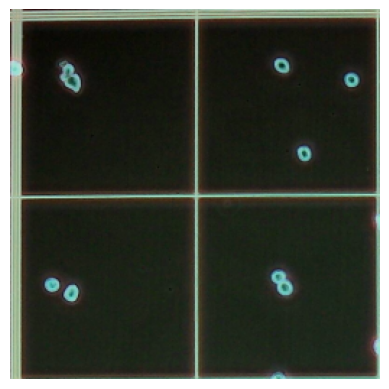

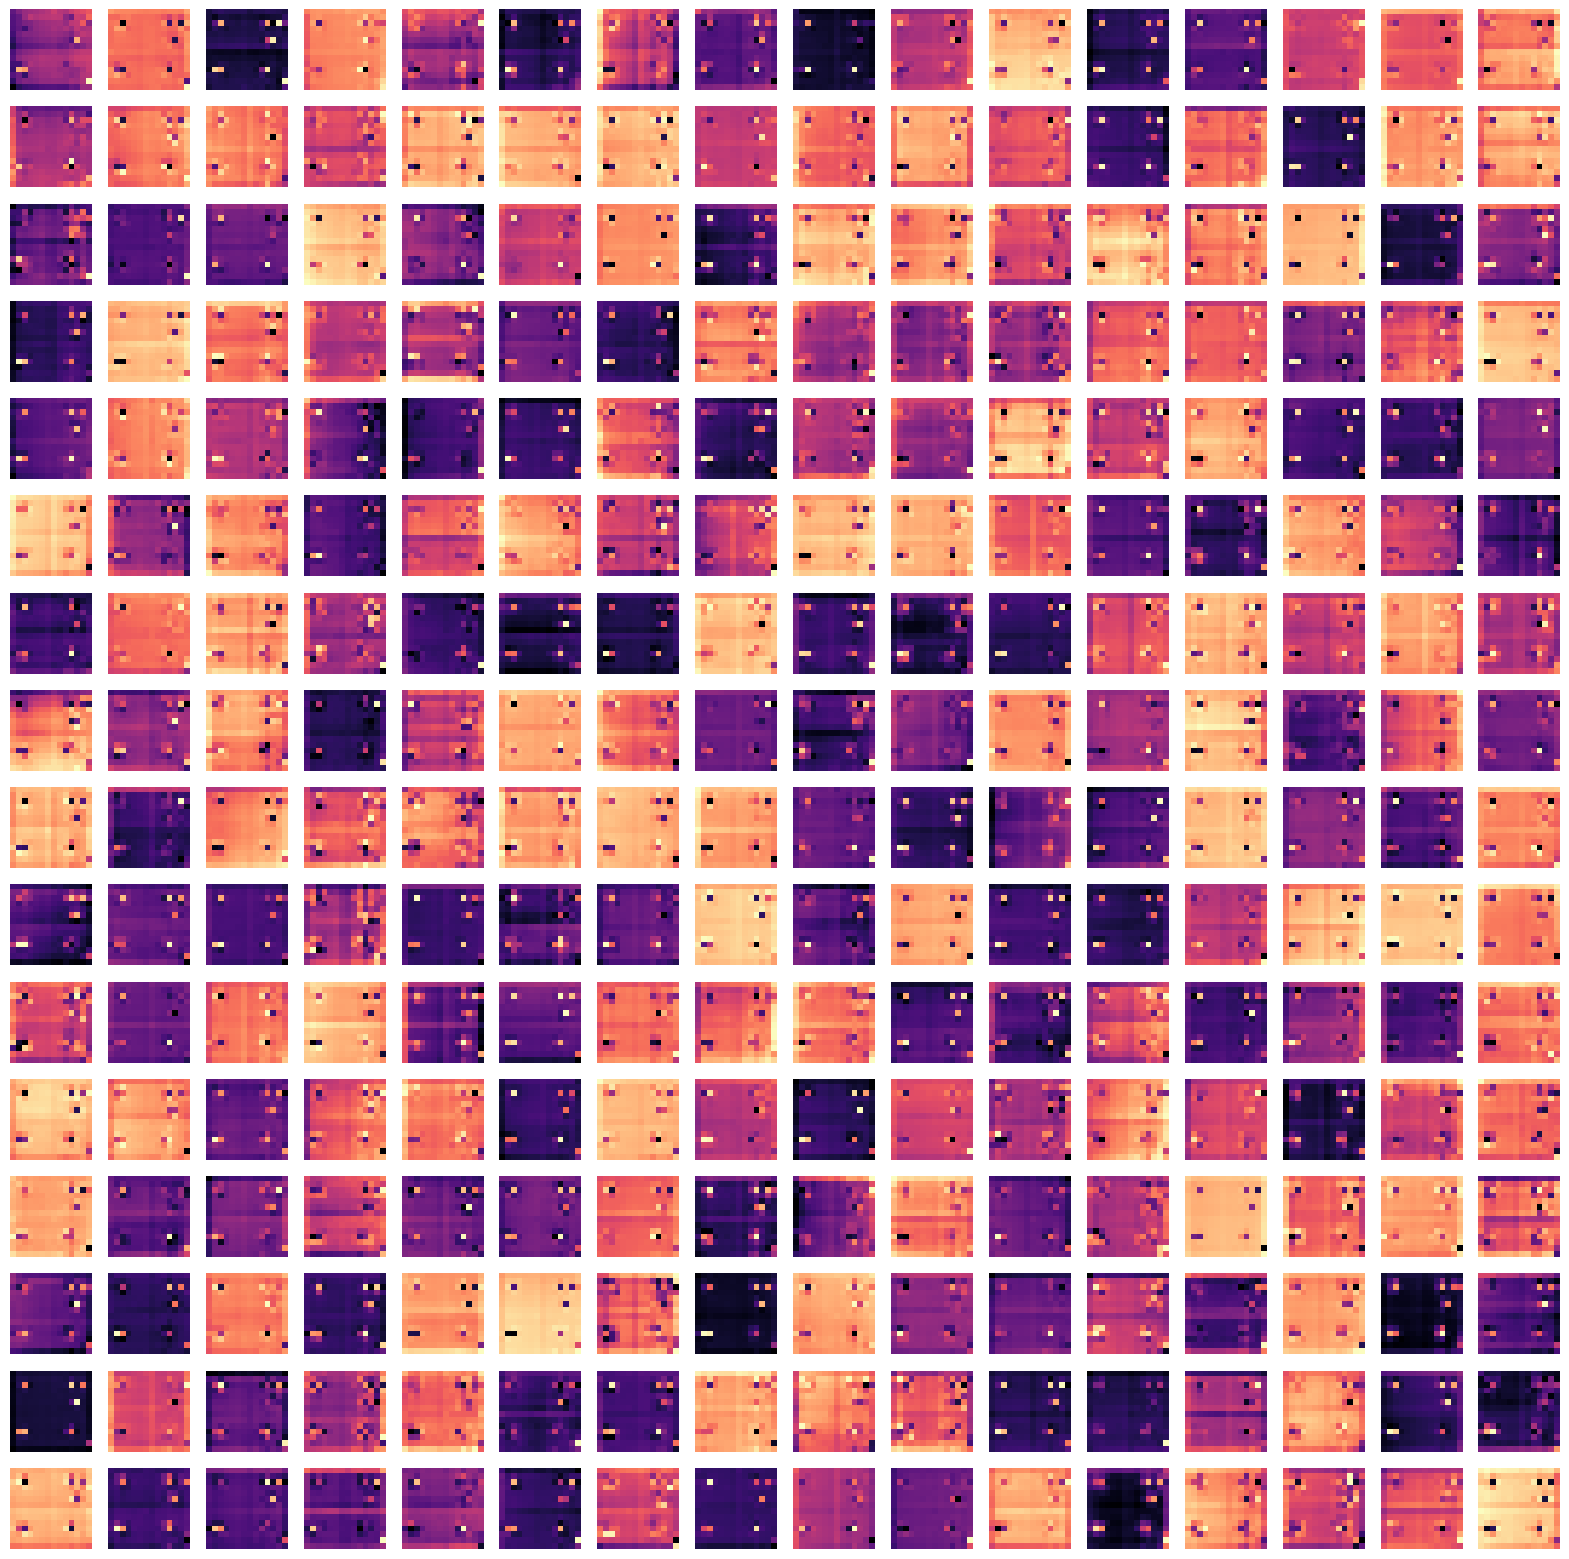

In [64]:
plt.imshow(img)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(16, 16, figsize=(20,20))

for i in range(16):
    for j in range(16):
        axs[i, j].imshow(output[0, i*16+j].cpu().numpy(), cmap = 'magma')
        axs[i, j].axis('off')

plt.show()

In [87]:
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'output' is your feature tensor of shape (256, 14, 14)
# Replace 'output' with your actual tensor variable name
features = output.squeeze().cpu().numpy()

# Check the shape of the features
print("Features shape:", features.shape)

# Flatten the features
features_flat = features.reshape(256, -1)

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features_flat)

# Check the shape of the PCA result
print("PCA result shape:", pca_result.shape)

# Create log directory
log_dir = 'logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Create a summary writer
writer = SummaryWriter(log_dir)

# Convert PCA result to a PyTorch tensor
pca_result_tensor = torch.tensor(pca_result, dtype=torch.float32)

# Check the shape of the PCA result tensor
print("PCA result tensor shape:", pca_result_tensor.shape)

# Step 3: Create metadata file
metadata_file = os.path.join(log_dir, 'metadata.tsv')
with open(metadata_file, 'w') as f:
    for i in range(pca_result_tensor.shape[0]):
        f.write(f"Feature_{i}\n")

# Verify the number of lines in metadata file
with open(metadata_file, 'r') as f:
    metadata_lines = f.readlines()
    print("Number of metadata entries:", len(metadata_lines))

# Step 4: Create sprite image
n = int(np.ceil(np.sqrt(features.shape[0])))
sprite_image = np.ones((n * 14, n * 14))

for i in range(n):
    for j in range(n):
        index = i * n + j
        if index < features.shape[0]:
            feature_image = features[index]
            sprite_image[i*14:(i+1)*14, j*14:(j+1)*14] = feature_image

# Save the sprite image
sprite_file = os.path.join(log_dir, 'sprite.png')
plt.imsave(sprite_file, sprite_image, cmap='gray')

# Check the shape of features tensor for label_img
features_tensor = torch.tensor(features).unsqueeze(1)
print("Features tensor shape for label_img:", features_tensor.shape)

# Add embeddings to TensorBoard
writer.add_embedding(
    mat=pca_result_tensor, 
    # metadata=metadata_file, 
    label_img=features_tensor
)

# Close the writer
writer.close()

print(f"Run `tensorboard --logdir={log_dir}` to visualize the embeddings.")


Features shape: (256, 14, 14)
PCA result shape: (256, 3)
PCA result tensor shape: torch.Size([256, 3])
Number of metadata entries: 256
Features tensor shape for label_img: torch.Size([256, 1, 14, 14])
Run `tensorboard --logdir=logs` to visualize the embeddings.
